# VEME NGS Module: Analyzing Single Cell Data with Scanpy 

This notebook serves as an alternative to the 'VEME_Single_Cell.ipynb' notebook, where instead of using individual python modules to conduct analysis of the single cell RNA-seq data, this will use scanpy to conduct the analysis in one python module.  This notebook uses the same data from Melms et al. found at https://www.nature.com/articles/s41586-021-03569-1.  The steps for using scanpy to conduct the analysis can be found at https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html.

In [1]:
%pip uninstall numpy -y
%pip install numpy==1.21.0

Found existing installation: numpy 1.21.0
Uninstalling numpy-1.21.0:
  Successfully uninstalled numpy-1.21.0
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.21.0-cp38-cp38-macosx_10_9_x86_64.whl (16.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-network 0.31.0 requires numpy>=1.22.4, but you have numpy 1.21.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


### ----- MUST RESTART THE KERNEL BEFORE RUNNING -----

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import warnings
warnings.filterwarnings("ignore")

## 1.) Load in processed cell by gene counts matrix

In [2]:
counts = pd.read_csv("processed_data_10_percent.csv.gz", compression = "gzip", index_col = 0)
counts.shape

(11631, 2000)

In [3]:
counts.head()

,IGKC,SFTPC,SFTPA2,IGLC2,SFTPA1,IGHG3,CEMIP,COL1A1,IGLC1,SERPINE1,...,SFTA2,AC027808.2,PFN1,FOXJ1,SLC6A4,B3GNT5,FCRL1,TNFSF15,FSTL3,RXFP1
TAGGTACCATCATCTT-1_26,-0.179842,-0.302550,-0.270006,-0.104097,-0.268914,-0.155862,0.741096,0.201830,-0.115725,1.898368,...,0.016689,0.754596,-0.089637,-0.085610,-0.150100,-0.191087,-0.238788,-0.035274,0.163645,-0.087180
GTGCTTCGTGATGTAA-1_6,-0.171866,-0.316475,-0.267945,-0.103750,-0.268676,-0.155157,-0.346043,-0.319355,-0.115247,-0.492898,...,-0.159329,-0.136208,-0.196339,-0.085418,-0.122912,-0.320130,0.086005,0.004053,-0.241957,-0.100204
AAGCGAGTCCCGAGGT-1_26,-0.172125,-0.288306,-0.269466,-0.103818,-0.269138,-0.154876,-0.439812,-0.323876,-0.115633,-0.428029,...,-0.159884,0.226238,0.238889,-0.085610,-0.154954,-0.050412,0.714853,-0.106925,-0.182437,-0.068454
CGGGACTCATCATGAC-1_2,-0.172138,-0.311949,-0.261401,-0.103819,-0.258226,-0.154678,1.220277,-0.412570,-0.115634,-0.487244,...,0.069381,-0.105492,-0.168247,-0.085610,-0.195910,-0.223893,-0.250511,-0.509968,0.248163,-0.048463
GTTGTAGCAGCTGCCA-1_3,-0.172138,-0.316067,-0.269466,-0.103819,-0.269138,-0.154678,-0.342670,-0.324338,-0.115634,-0.503068,...,-0.159884,-0.105492,-0.168256,-0.085610,-0.151069,-0.256365,-0.250511,-0.068950,-0.242164,-0.108532


## 2.) Convert the counts matrix to an anndata data structure

In [4]:
adata = ad.AnnData(counts)
adata.obs_names = list(counts.index)
adata.var_names = list(counts.columns)
adata.var['gene_ids'] = list(counts.columns)

# Load in the metadata file to annotate the cells
metadata = pd.read_csv("GSE171524_lung_metaData.txt", sep = "\t")
metadata = metadata.iloc[1:] # Remove first row, irrelevant
metadata = metadata[(metadata["NAME"].isin(counts.index))]
metadata = metadata.set_index("NAME")
metadata = metadata.reindex(index = counts.index)
metadata = metadata.reset_index()

# Add annotations to anndata
cell_type_main = list(metadata["cell_type_main"])
cell_type_inter = list(metadata["cell_type_intermediate"])
cell_type_fine = list(metadata["cell_type_fine"])
adata.obs["cell_type_main"] = cell_type_main
adata.obs["cell_type_intermediate"] = cell_type_inter
adata.obs["cell_type_fine"] = cell_type_fine
adata

AnnData object with n_obs × n_vars = 11631 × 2000
    obs: 'cell_type_main', 'cell_type_intermediate', 'cell_type_fine'
    var: 'gene_ids'

## 3.) Compute the neighborhood graph and cluster

Like it's done in line 8 of 'VEME_Single_Cell.ipynb, we need to compute the neighborhood graph prior to clustering.  Additionally, we need to compute the neighborhood graph of the dimensionality reduced version of the data, which in scanpy can all be done at once.

In [5]:
# Compute with 50 neighbors on 30 principle components

sc.pp.neighbors(adata, n_neighbors=50, n_pcs=30)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [6]:
# Compute the louvain clusters

sc.tl.louvain(adata)

## 4.) Generate UMAP embedding and visualize clusters and cell types

### a. Generate the UMAP embeddings

In [7]:
sc.tl.umap(adata)

### b. Visualize louvain clusters in the UMAP space

... storing 'cell_type_main' as categorical
... storing 'cell_type_intermediate' as categorical
... storing 'cell_type_fine' as categorical


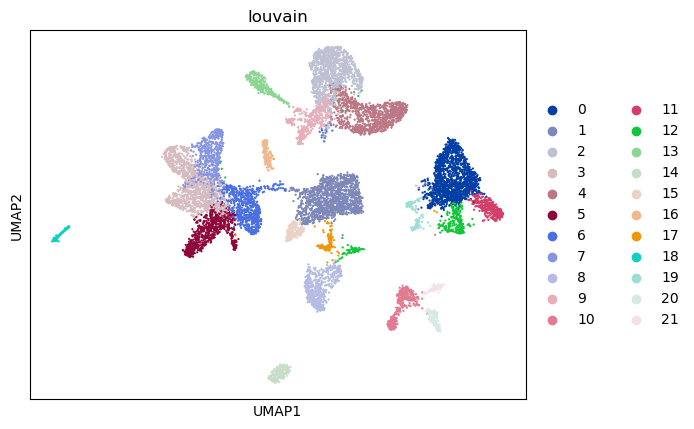

In [8]:
sc.pl.umap(adata, color=['louvain'])

### c. Visualize the main cell types in the UMAP space

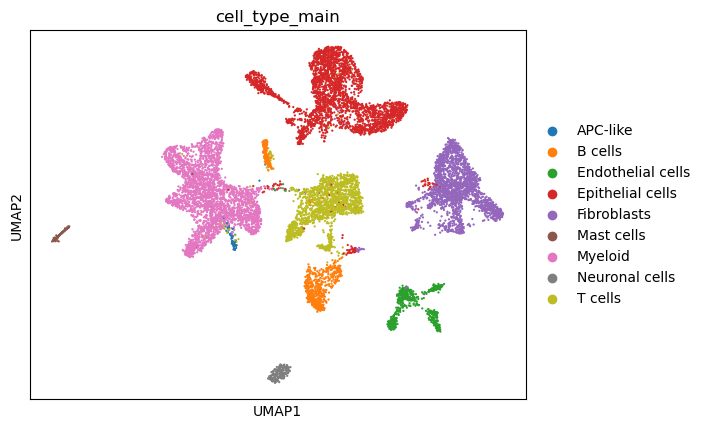

In [9]:
sc.pl.umap(adata, color=['cell_type_main'])

### d. Visualize the intermediate cell types in UMAP space

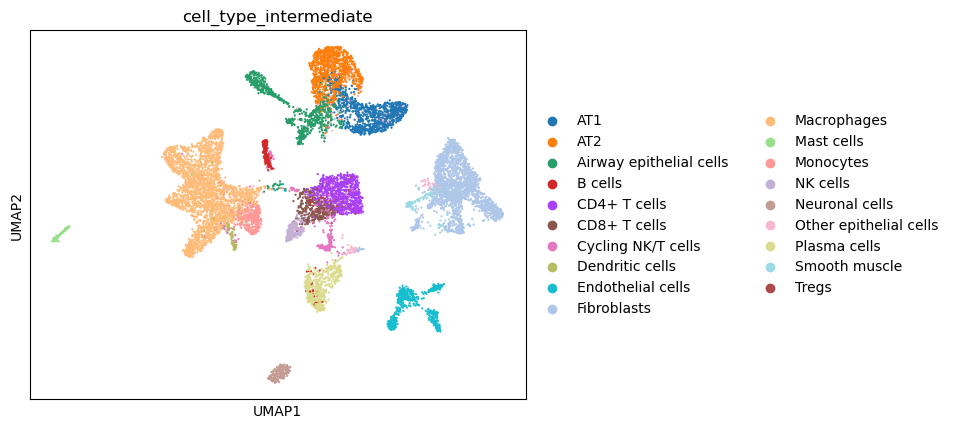

In [10]:
sc.pl.umap(adata, color=['cell_type_intermediate'])

## EXTRA: Finding marker genes in scanpy through differential expression

This is extra becuase marker gene analysis can be done with NS-Forest, which uses machine learning rather than differential expression.  The NS-forest algorithm selects marker genes that optimally descriminate among cell types, where differential expression uses test statistics to look for over expressed genes in a given cell type.  

### a. Explore top 10 differentially expressed in each intermediate cell type using Wilcoxon rank-sum

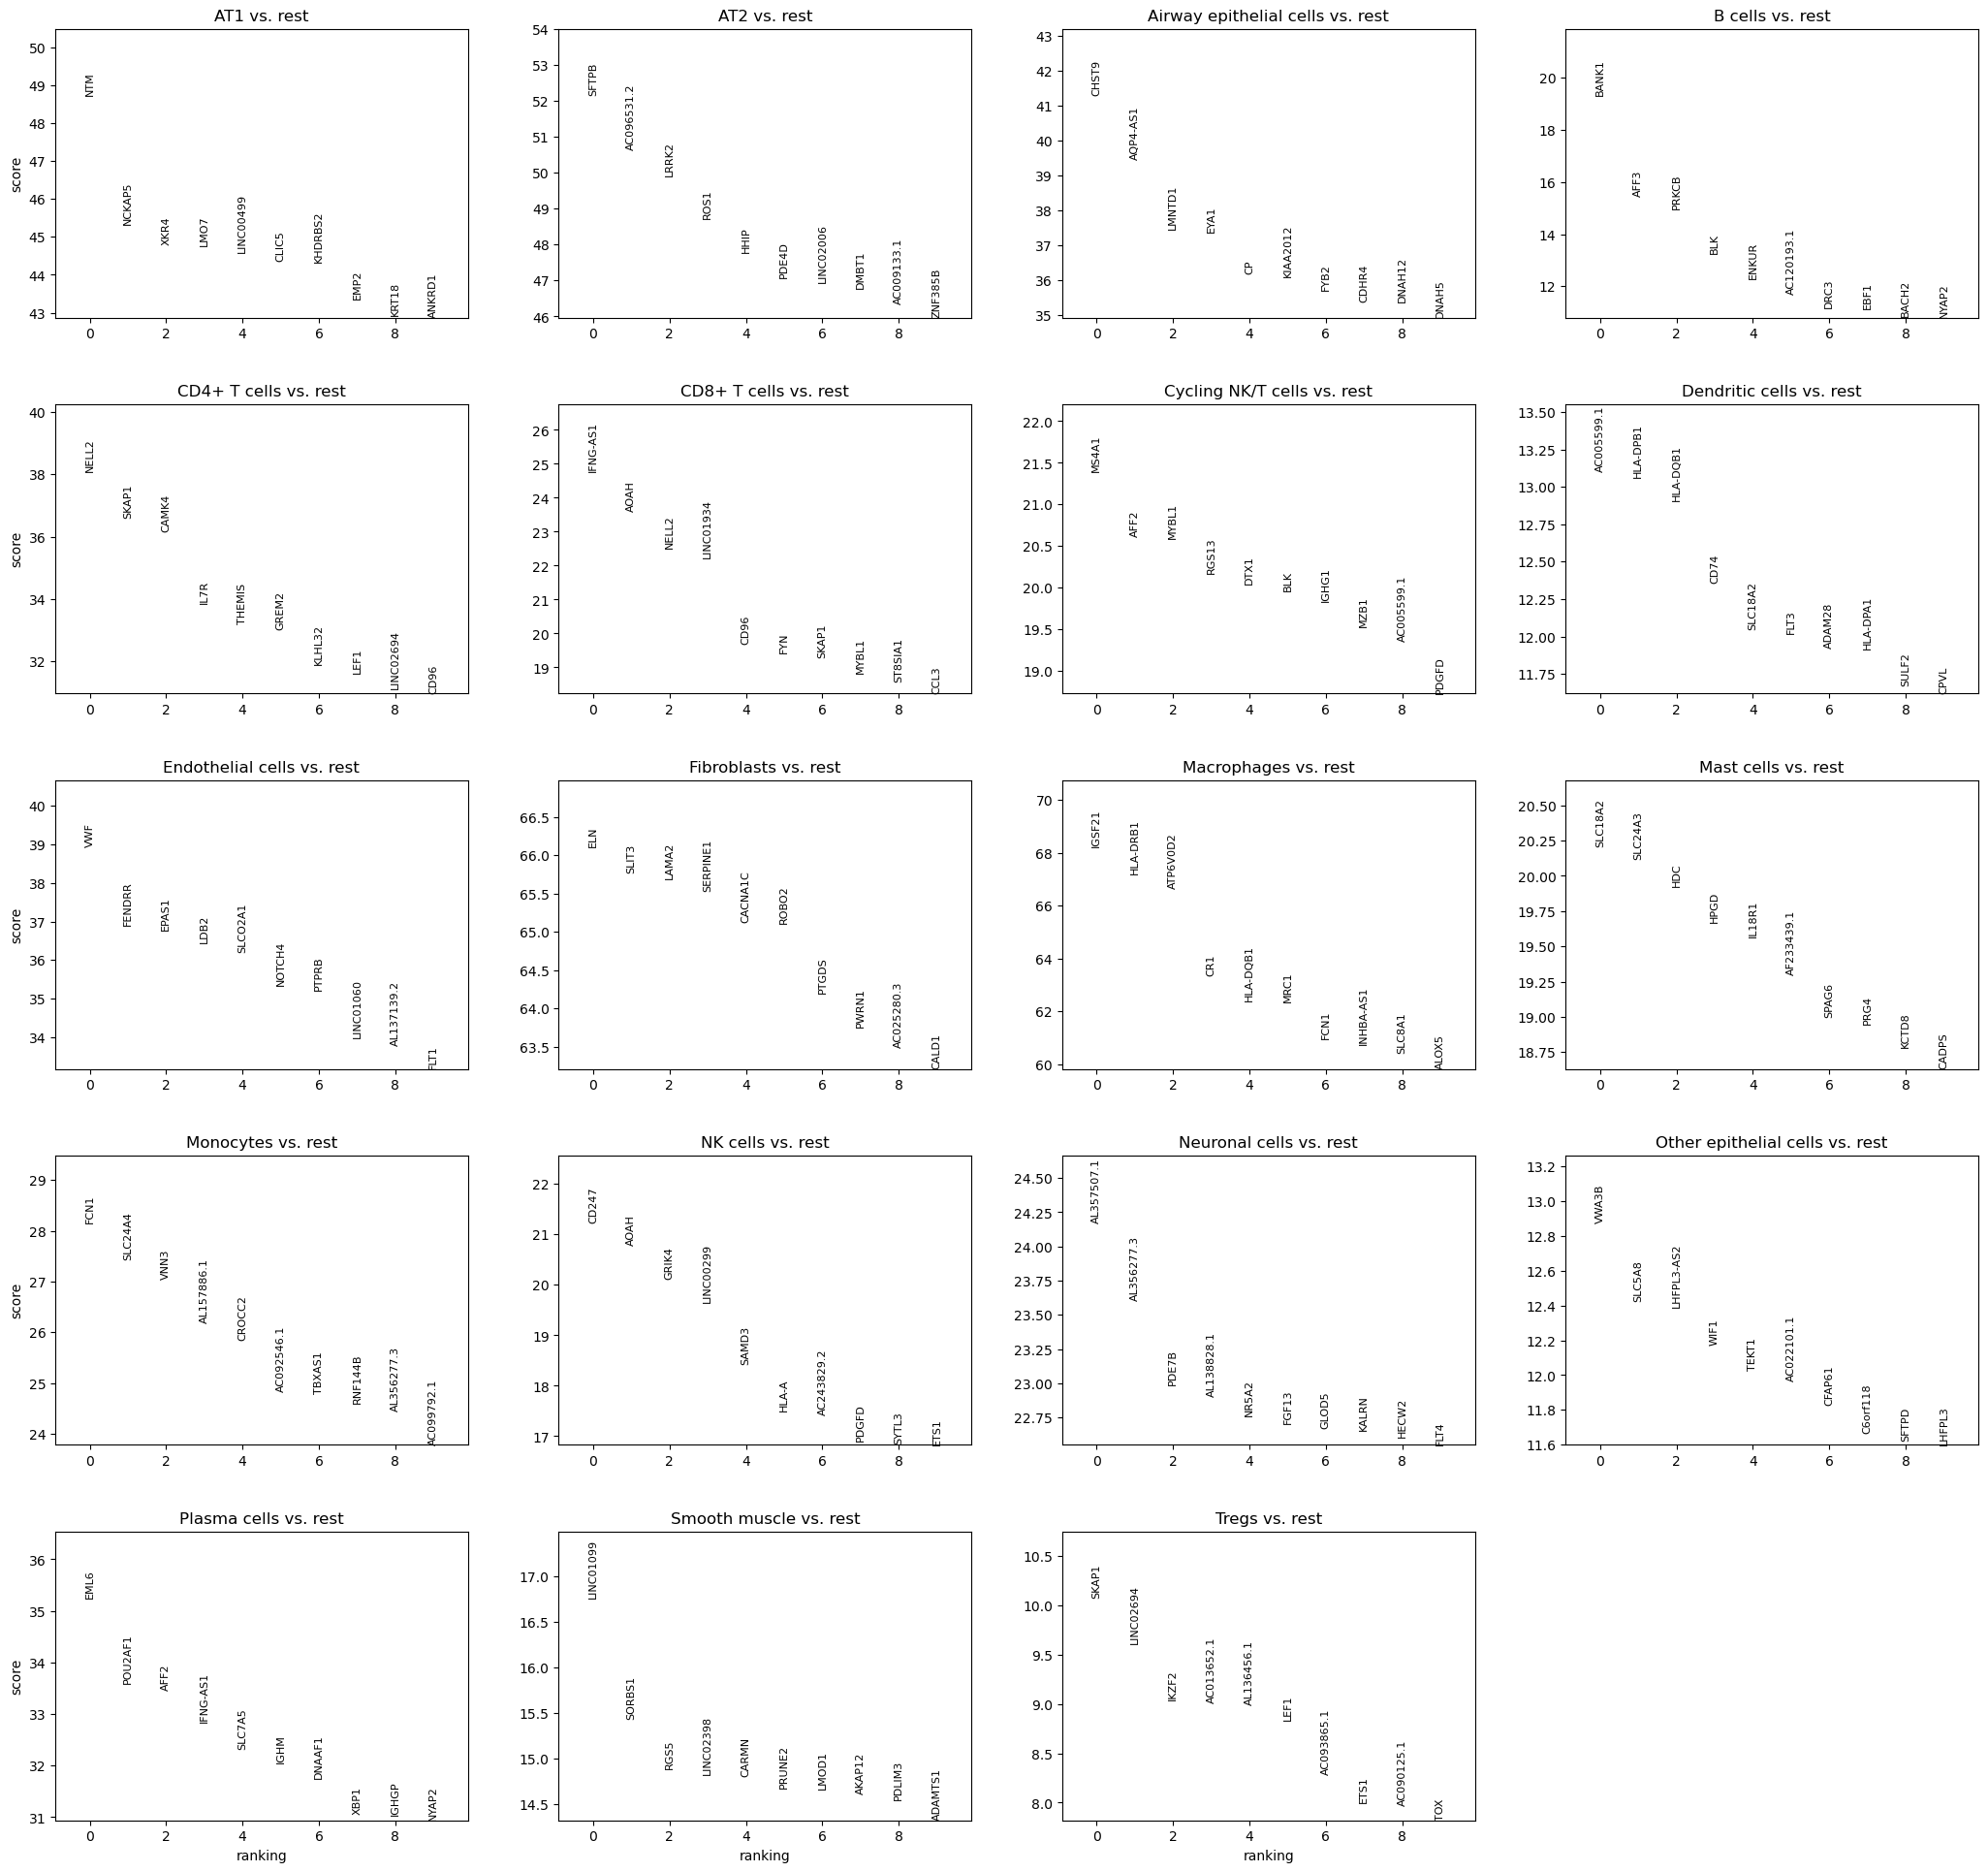

In [11]:
sc.tl.rank_genes_groups(adata, 'cell_type_intermediate', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

### b. Better visualize the expression of these markers

In [12]:
sc.tl.rank_genes_groups(adata, groupby='cell_type_intermediate', method='wilcoxon')

1.) Visualize markers with a dot plot

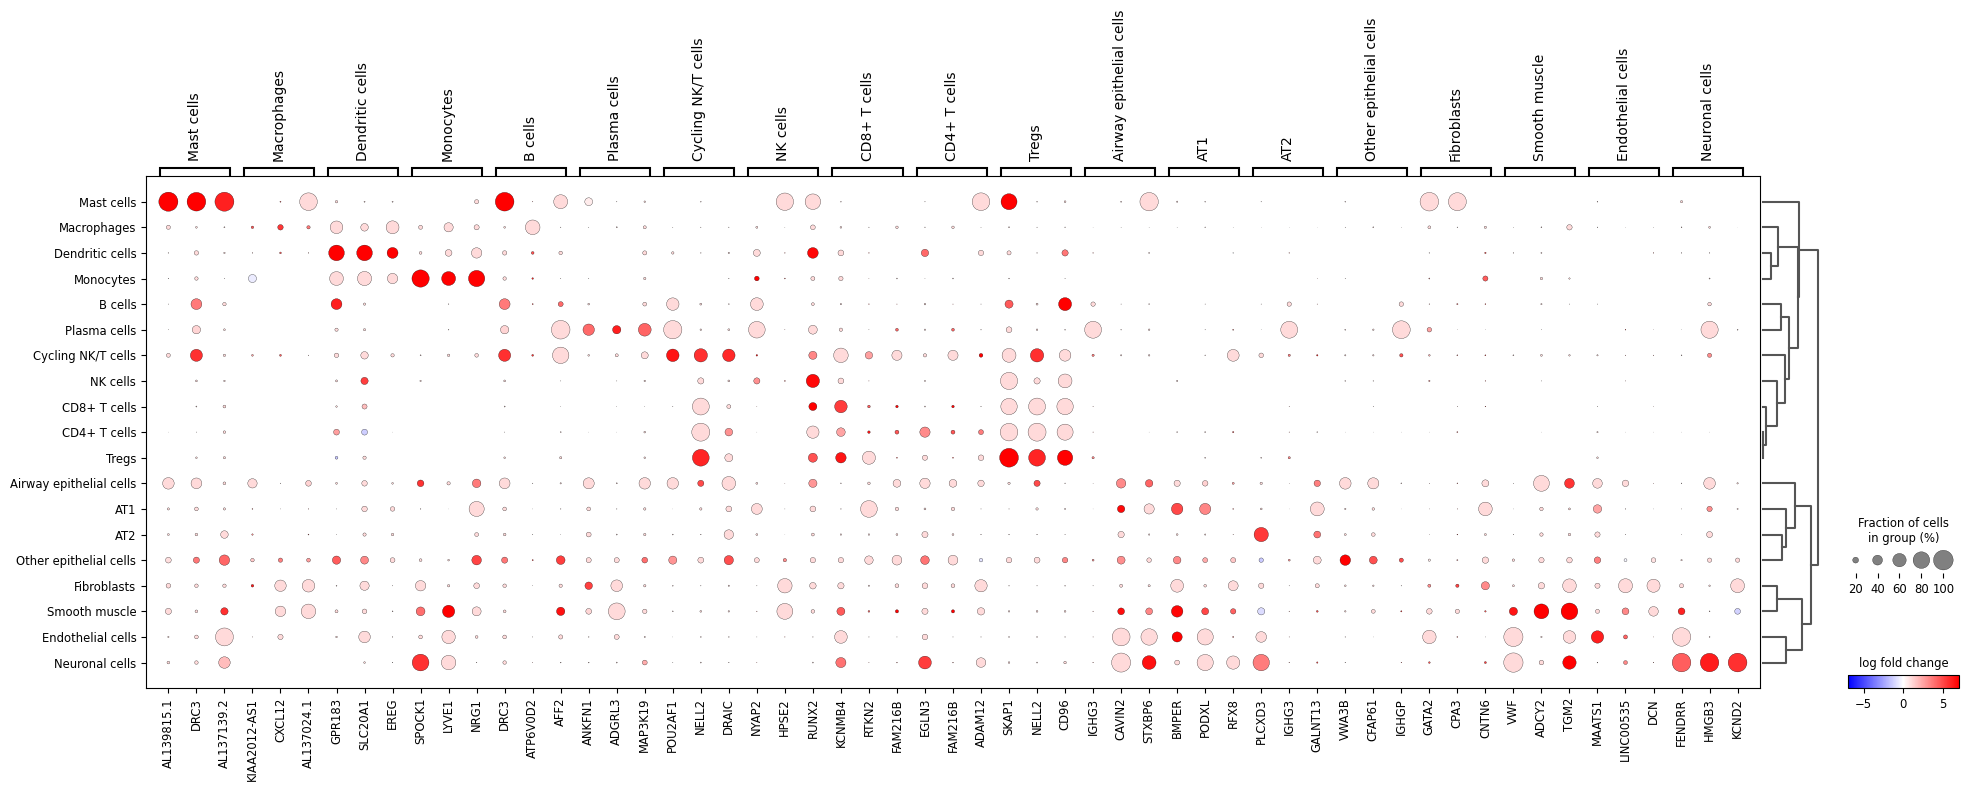

In [13]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=3, values_to_plot='logfoldchanges', min_logfoldchange=3, vmax=7, vmin=-7, cmap='bwr')

2.) Visualize markers with a matrix heatmap

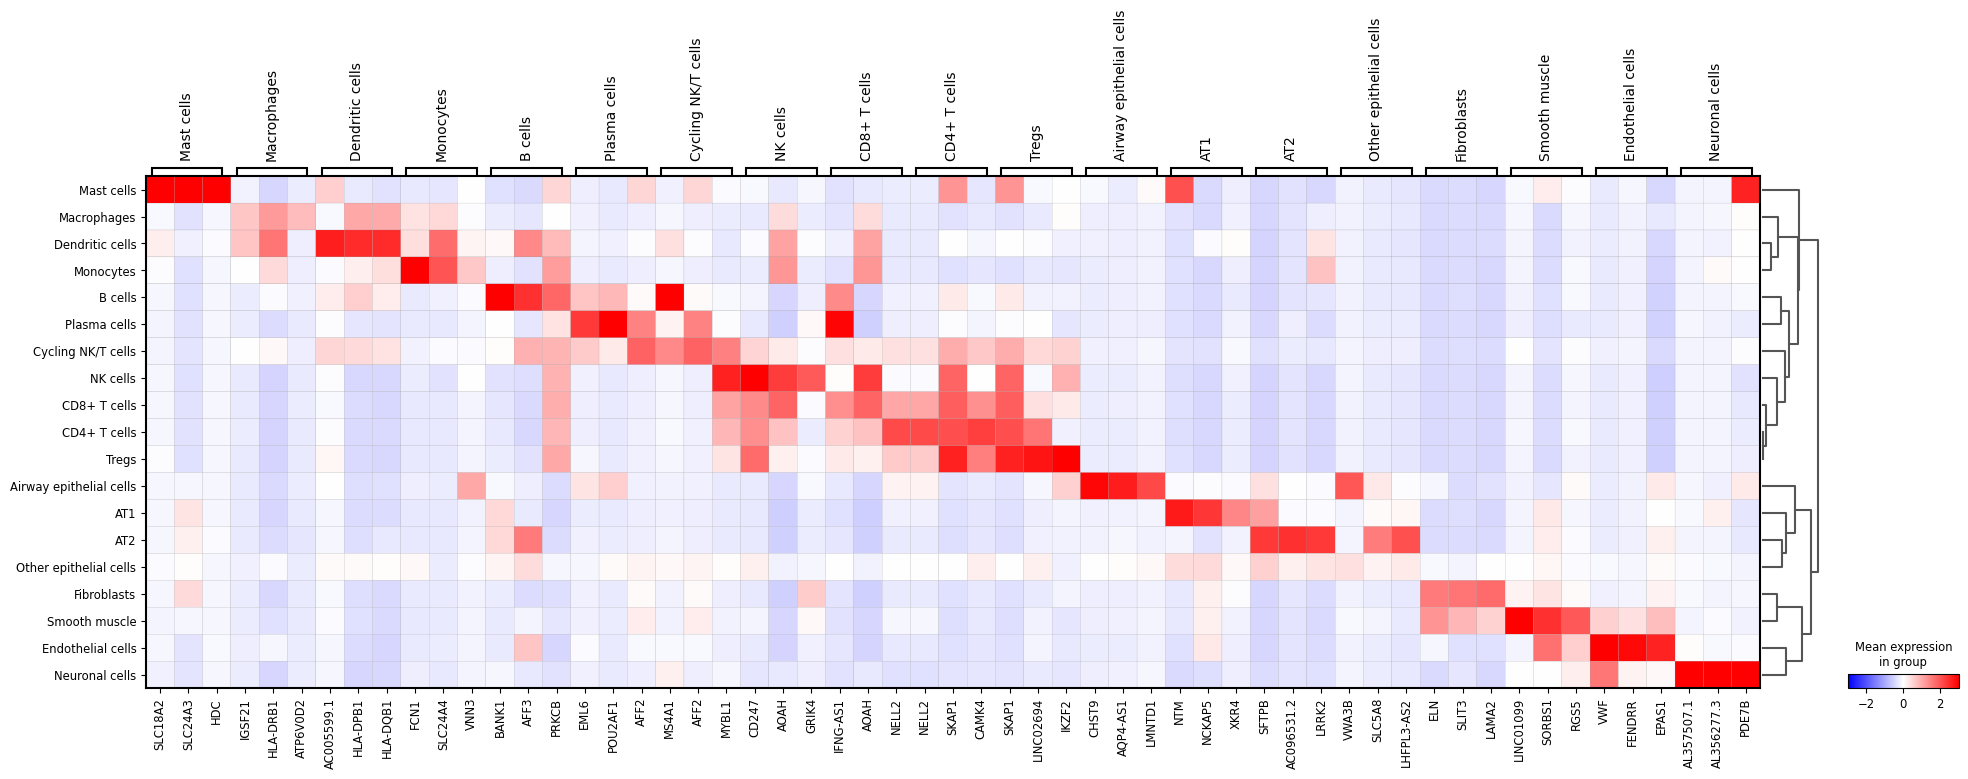

In [14]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=3, use_raw=False, vmin=-3, vmax=3, cmap='bwr')

## Save results to anndata object

In [15]:
adata.write("covid_scRNAseq.h5ad")

### NOTE: We will used the saved covid_scRNAseq.h5ad file in CELLxGENE visualization tutorial